In [17]:
"""
安装pySWATPlus
   SPOTPY
   mpi4py
   MS mpi

0、pySWATPlus 下载rar解压，用anaconda prompt界面cd到解压的文件夹，用pytohn setup.py install安装

一、TxtinoutReader
1.必须指定工作路径，否则工作路径会变成copy里的路径
2.必须使用绝对路径
3.网页教程的参数格式不对
4.改变参数，不指定行id时，用 None

二、FileReader
1.读取文件不指定index时，必须用None,不可省略
2.usecols省略的话，读取的df为空

三、定义SWAT函数给SPOTPY用时注意以下几点
1、SWAT模型的参数定义不要超过上下界，如(0, 1)用(0.001, 0.999)代替
2、用pySWATPlus定义函数给simulation用时，尽量把只修改一次文件的语句放函数外面
   例如， reader.set_beginning_and_end_year(2017, 2018)
         reader.set_warmup(1)
         reader.enable_object_in_print_prt("channel_sd", True, False, False, False)
   这些直接在root文件夹里手动改就行，不要写成代码，因为用mpiexec并行处理时，会导致文件被意想不到的修改

"""
%reset -f
import os
import pandas as pd
import numpy as np
import spotpy as sp
from spotpy.likelihoods import gaussianLikelihoodMeasErrorOut as gauss
import shutil
import mpi4py
import sys
from pySWATPlus.TxtinoutReader import TxtinoutReader
from pySWATPlus.FileReader import FileReader
from matplotlib import pyplot as plt
from datetime import datetime
# cwd = "E:/SPOTPY-and-pySWATPlus"
cwd = "E:/BaiduSyncdisk/Code/Python/SPOTPY-and-pySWATPlus"

# 用pySWATPlus定义huron_swat函数

In [18]:
def huron_swat(reader, params, tpl_params, copy_path, output_scale="day", show_output=False, delete_copy=True):
    result = reader.copy_and_run(dir=copy_path,
                                 params=params,
                                 tpl_params=tpl_params,
                                 show_output=show_output
                                 )
    reader = FileReader(os.path.join(result, "basin_aqu_day.txt"),
                        has_units = True,
                        index=None,
                        usecols=["mon", "day", "yr", "unit", "no3_lat"],
                        filter_by={"unit": 1}
                        )
    res = reader.df
    if output_scale == "mon":
        res = (res.
               groupby(["yr", "mon"]).
               agg({"no3_lat": np.sum}).
               reset_index())
        res["Date"] = pd.to_datetime(pd.DataFrame({"year": res["yr"],
                                                   "month": res["mon"],
                                                   "day": 1}))
        res.drop(columns=["yr", "mon"], inplace=True)
    elif output_scale == "day":
        res["Date"] = pd.to_datetime(pd.DataFrame({"year": res["yr"],
                                                   "month": res["mon"],
                                                   "day": res["day"]}))
        res.drop(columns=["mon", "day", "yr", "unit"], inplace=True)
    if delete_copy:
        shutil.rmtree(result, ignore_errors=True)
    os.chdir(cwd) #改回当前路径
    return res

# 定义SPOTPY类

In [19]:
class spot_swat():
    def __init__(self, TxtInOut_abspath, copy_path, start_print, end_print, 
                 output_scale="day", prior=sp.parameter.Uniform, obj_func=None,
                 show_output=False, delete_copy=True):
        self.reader = TxtinoutReader(TxtInOut_abspath)
        self.copy_path = copy_path
        self.start = start_print
        self.end = end_print
        self.output_scale = output_scale
        self.obj_func = obj_func
        self.show_output = show_output
        self.delete_copy = delete_copy
    
        self.params = [prior('alpha_bf', 0.0001, 0.9999), #0
                       prior('bf_max', 0.0001, 1.9999),
                       prior('dep_bot', 0.0001, 9.9999),
                       prior('dep_wt', 0.0001, 9.9999),
                       prior('flo_dist', 0.0001, 199.9999),
                       prior('flo_min', 0.0001, 49.9999),
                       prior('gw_flo', 0.0001, 1.9999),
                       prior('no3_n', 0.0001, 999.9999),
                       prior('rchg_dp', 0.0001, 0.9999),
                       prior('revap', 0.0201, 0.1999), #9
                       prior('revap_min', 0.0001, 49.9999),
                       prior('spec_yld', 0.0001, 0.4999),
                       prior('hl_no3n', 0.0001, 199.9999),
                       prior('cn_a', 30.0001, 69.9999),
                       prior('cn_b', 50.0001, 79.9999),
                       prior('cn_c', 70.0001, 89.9999),
                       prior('cn_d', 80.0001, 94.9999),
                       prior('can_max', 0.0001, 99.9999),
                       prior('cn3_swf', 0.0001, 0.9999),
                       prior('epco', 0.0001, 0.9999), #19
                       prior('esco', 0.0001, 0.9999),
                       prior('lat_ttime', 0.5001, 179.9999),
                       prior('latq_co', 0.0001, 0.9999),
                       prior('perco', 0.0001, 0.9999),
                       prior('pet_co', 0.7001, 1.2999),
                       prior('exp_co', 0.0001, 0.9999),
                       prior('fr_hum_act', 0.0001, 0.9999),
                       prior('hum_c_n', 8.0001, 11.9999),
                       prior('nitrate', 0.0001, 99.9999),
                       prior('ovn', 0.0101, 0.6999), #29
                       prior('denit_exp', 0.0001, 2.9999),
                       prior('denit_frac', 0.0001, 0.9999),
                       prior('evap_adj', 0.5001, 0.9999),
                       prior('lai_noevap', 0.0001, 9.9999),
                       prior('msk_co1', 0.0001, 9.9999),
                       prior('msk_co2', 0.0001, 9.9999),
                       prior('msk_x', 0.0001, 0.2999),
                       prior('n_fix_max', 1.0001, 19.9999),
                       prior('n_perc', 0.0001, 0.9999),
                       prior('n_uptake', 0.0001, 99.9999), #39
                       prior('nperco_lchtile', 0.0001, 0.9999),
                       prior('orgn_min', 0.0011, 0.0029),
                       prior('rsd_cover', 0.1001, 0.4999),
                       prior('rsd_decay', 0.0001, 0.0499),
                       prior('rsd_decomp', 0.0201, 0.0999),
                       prior('scoef', 0.0001, 0.9999),
                       prior('surq_exp', 1.0001, 2.9999),
                       prior('surq_lag', 1.0001, 23.9999),
                       prior('sw_init', 0.0001, 0.9999),
                       prior('cov50', 0.0001, 0.90), #49
                       prior('fall_tmp', -4.9999, 4.9999), 
                       prior('melt_max_min', 0.0001, 9.9999),
                       prior('melt_tmp', -4.9999, 4.9999),
                       prior('snow_h2o', 0.0001, 499.9999),
                       prior('snow_init', 0.0001, 999.9999),
                       prior('tmp_lag', 0.0001, 0.9999),
                       prior('dist', 7600.0001, 29999.9999),
                       prior('dp', 0.0001, 5999.9999),
                       prior('drain', 10.0001, 50.9999), 
                       prior('lag', 0.0001, 99.9999), #59
                       prior('lat_kast', 0.0101, 3.9999),
                       prior('pump', 0.0001, 9.9999),
                       prior('rad', 3.0001, 39.9999),
                       prior('t_fc', 0.0001, 99.9999),
                       prior('fert_1', 0.0001, 999.9999),
                       prior('fert_2', 0.0001, 999.9999),
                       prior('fert_3', 0.0001, 999.9999),
                       prior('fert_4', 0.0001, 999.9999),
                       prior('fert_5', 0.0001, 999.9999),
                       prior('fert_6', 0.0001, 999.9999),
                       prior('fert_7', 0.0001, 999.9999),
                       prior('fert_8', 0.0001, 999.9999),
                       prior('fert_9', 0.0001, 999.9999),
                       prior('fert_10', 0.0001, 999.9999),
                       prior('fert_11', 0.0001, 999.9999),
                       prior('fert_12', 0.0001, 999.9999),
                       prior('rsd_init', 0.0001, 9999.9999),
                       prior('awc', 0.0001, 0.9999),
                       prior('soil_k', 0.0001, 1999.9999),
                       ]
    def parameters(self):
        return sp.parameter.generate(self.params)

    def simulation(self, vector):
        par = np.array(vector)
        best_par = np.loadtxt("best_par.csv", dtype=float)
        params = {"aquifer.aqu":("name", [(None, 'alpha_bf', best_par[0]), 
                                          (None, 'bf_max', best_par[1]), 
                                          (None, 'dep_bot', best_par[2]),
                                          (None, 'dep_wt', best_par[3]),
                                          (None, 'flo_dist', best_par[4]), 
                                          (None, 'flo_min', best_par[5]), 
                                          (None, 'gw_flo', best_par[6]),  
                                          (None, 'no3_n', best_par[7]),
                                          (None, 'rchg_dp', best_par[8]),
                                          (None, 'revap', best_par[9]),
                                          (None, 'revap_min', best_par[10]),
                                          (None, 'spec_yld', best_par[11]),
                                          (None, 'hl_no3n', best_par[12]),
                                          ],
                                 ),
                  "cntable.lum":("description", [(None,"cn_a", best_par[13]),
                                                 (None,"cn_b", best_par[14]), 
                                                 (None,"cn_c", best_par[15]), 
                                                 (None,"cn_d", best_par[16]),  
                                                 ],
                                 ),
                  "hydrology.hyd":("name", [(None, 'can_max', best_par[17]),
                                            (None, 'cn3_swf', best_par[18]),
                                            (None, 'epco', best_par[19]),
                                            (None, 'esco', best_par[20]),
                                            (None, 'lat_ttime', best_par[21]),
                                            (None, 'latq_co', best_par[22]),
                                            (None, 'perco', best_par[23]),
                                            (None, 'pet_co', best_par[24]),
                                            ],
                                   ),
                  "nutrients.sol":("name", [(None, 'exp_co', best_par[25]),
                                            (None, 'fr_hum_act', best_par[26]), 
                                            (None, 'hum_c_n', best_par[27]),
                                            (None, 'nitrate', best_par[28]),
                                            ],
                                   ),
                  "ovn_table.lum":("name", [(None, 'ovn_mean', best_par[29]),
                                            (None, 'ovn_min', best_par[29]),
                                            (None, 'ovn_max', best_par[29])
                                            ],
                                   ),
                  "parameters.bsn":("igen", [(None, 'denit_exp', best_par[30]), 
                                             (None, 'denit_frac', best_par[31]),
                                             (None, 'evap_adj', best_par[32]),
                                             (None, 'lai_noevap', best_par[33]),
                                             (None, 'msk_co1', best_par[34]),
                                             (None, 'msk_co2', best_par[35]),
                                             (None, 'msk_x', best_par[36]),
                                             (None, 'n_fix_max', best_par[37]),
                                             (None, 'n_perc', best_par[38]),
                                             (None, 'n_uptake', best_par[39]),
                                             (None, 'nperco_lchtile', best_par[40]),
                                             (None, 'orgn_min', best_par[41]),
                                             (None, 'rsd_cover', best_par[42]),
                                             (None, 'rsd_decay', best_par[43]),
                                             (None, 'rsd_decomp', best_par[44]),
                                             (None, 'scoef', best_par[45]),
                                             (None, 'surq_exp', best_par[46]),
                                             (None, 'surq_lag', best_par[47]),
                                             (None, 'sw_init', best_par[48]),
                                             ],
                                    ),
                  "snow.sno":("name", [(None, 'cov50', best_par[49]),
                                       (None, 'fall_tmp', best_par[50]),
                                       (None, 'melt_max', best_par[51]),
                                       (None, 'melt_min', best_par[51]),
                                       (None, 'melt_tmp', best_par[52]),
                                       (None, 'snow_h2o', best_par[53]),
                                       (None, 'snow_init', best_par[54]),
                                       (None, 'tmp_lag', best_par[55]),
                                       ],
                              ),
                  "tiledrain.str":("name", [(None, 'dist', best_par[56]),
                                            (None, 'dp', best_par[57]),
                                            (None, 'drain', best_par[58]),
                                            (None, 'lag', best_par[59]),
                                            (None, 'lat_ksat', best_par[60]),
                                            (None, 'pump', best_par[61]),
                                            (None, 'rad', best_par[62]),
                                            (None, 't_fc', best_par[63]),
                                            ],
                                   ),

                  }
        tpl_params = {"management.sch.tpl": {"fert_1": par[64],
                                             "fert_2": par[65],
                                             "fert_3": par[66],
                                             "fert_4": par[67],
                                             "fert_5": par[68],
                                             "fert_6": par[69],
                                             "fert_7": par[70],
                                             "fert_8": par[71],
                                             "fert_9": par[72],
                                             "fert_10": par[73],
                                             "fert_11": par[74],
                                             "fert_12": par[75],
                                             },
                      "plant.ini.tpl": {"rsd_init": best_par[76]},
                      "soils.sol.tpl": {"awc": best_par[77],
                                        "soil_k": best_par[78]},
                      }
        sim = huron_swat(self.reader, params, tpl_params, self.copy_path,
                         output_scale=self.output_scale,
                         show_output=self.show_output,
                         delete_copy=self.delete_copy)
        return sim["no3_lat"]*90643.0
    
    def evaluation(self):
        if self.output_scale == "day":
            obs = pd.read_csv(os.path.join(cwd,'TimeSeries\\daily_load.csv'))
        elif self.output_scale == "mon":
            obs = pd.read_csv(os.path.join(cwd,'TimeSeries\\monthly_load.csv'))
        obs["Date"] = pd.to_datetime(obs["Date"])
        obs = obs.loc[((obs["Date"] >= datetime.strptime(self.start, "%Y-%m-%d")) & (obs["Date"] <= datetime.strptime(self.end, "%Y-%m-%d"))),("Load_COND_min", "Load_COND_max")]
        return obs
    def objectivefunction(self, simulation, evaluation):
        if not self.obj_func:
            like = sp.objectivefunctions.nashsutcliffe(evaluation, simulation)
        else:
            like = self.obj_func(evaluation, simulation)
        return like
    

# 参数率定

In [20]:
# 源文件路径和复制文件路径
proj_path = os.path.join(cwd, "Cal_TxtInOut")
copy_path = os.path.join(cwd, "Cal_copy")

# 设置SWAT模拟时间范围
start_sim = "2017-01-01"
end_sim = "2020-12-31"

# 设置SWAT输出时间范围
start_print = "2018-02-01"
end_print = "2020-12-31"
warmup = 1

# 设置输出时间尺度
output_scale = "mon"

# 输出选项
show_output = True
delete_copy = False

# 目标函数
def obj_func(evaluation, simulation):
    evaluation = np.array(evaluation)
    simulation = np.array(simulation)
    e = np.where(simulation < evaluation[:, 0],
                 evaluation[:, 0] - simulation,
                 np.where(simulation > evaluation[:, 1],
                          evaluation[:, 1] - simulation,
                          0)
                 )
    o = np.zeros_like(e)
    return gauss(o, e)

# 实例化及采样
spot_setup = spot_swat(proj_path, copy_path, start_print, end_print,
                       obj_func=obj_func, output_scale=output_scale, 
                       show_output=show_output, delete_copy=delete_copy)

spot_setup.reader.set_simulation_time(start_sim, end_sim)
spot_setup.reader.set_print_time(start_print, end_print, warmup)
spot_setup.reader.enable_object_in_print_prt("basin_aqu", True, False, False, False)


# sampler = sp.algorithms.mc(spot_setup,
#                            dbname="Cal", 
#                            dbformat="csv",
#                            # parallel="mpi",
#                            )
# sampler.sample(repetitions=2,
#                # percentage_first_run=0.3,
#                # percentage_following_runs=0.3
#                # ngs=10,
#                )

In [ ]:
params = spot_setup.parameters()["random"]
sim = spot_setup.simulation(params)
obs = spot_setup.evaluation()

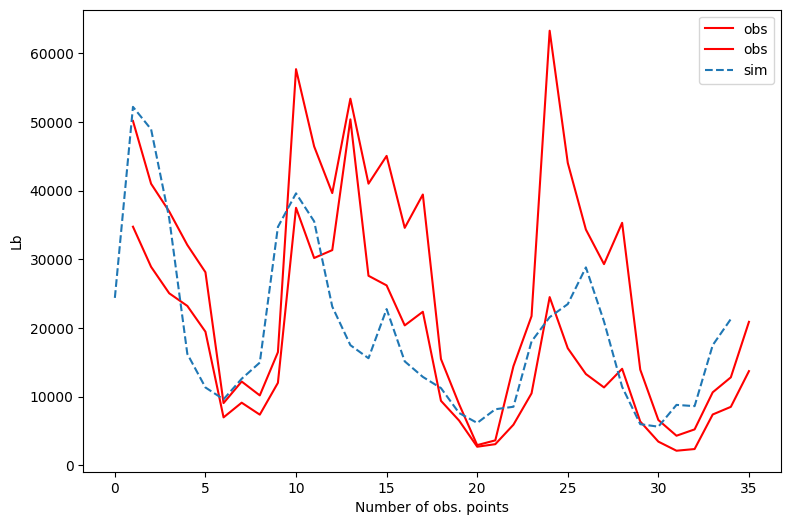

In [22]:

fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.plot(obs, "r-", label="obs")
ax.plot(sim, "--", label="sim")
ax.set_xlabel("Number of obs. points")
ax.set_ylabel("Lb")
ax.legend()

# Best sim

Run number 8765 has the lowest objectivefunction with: 8688.783


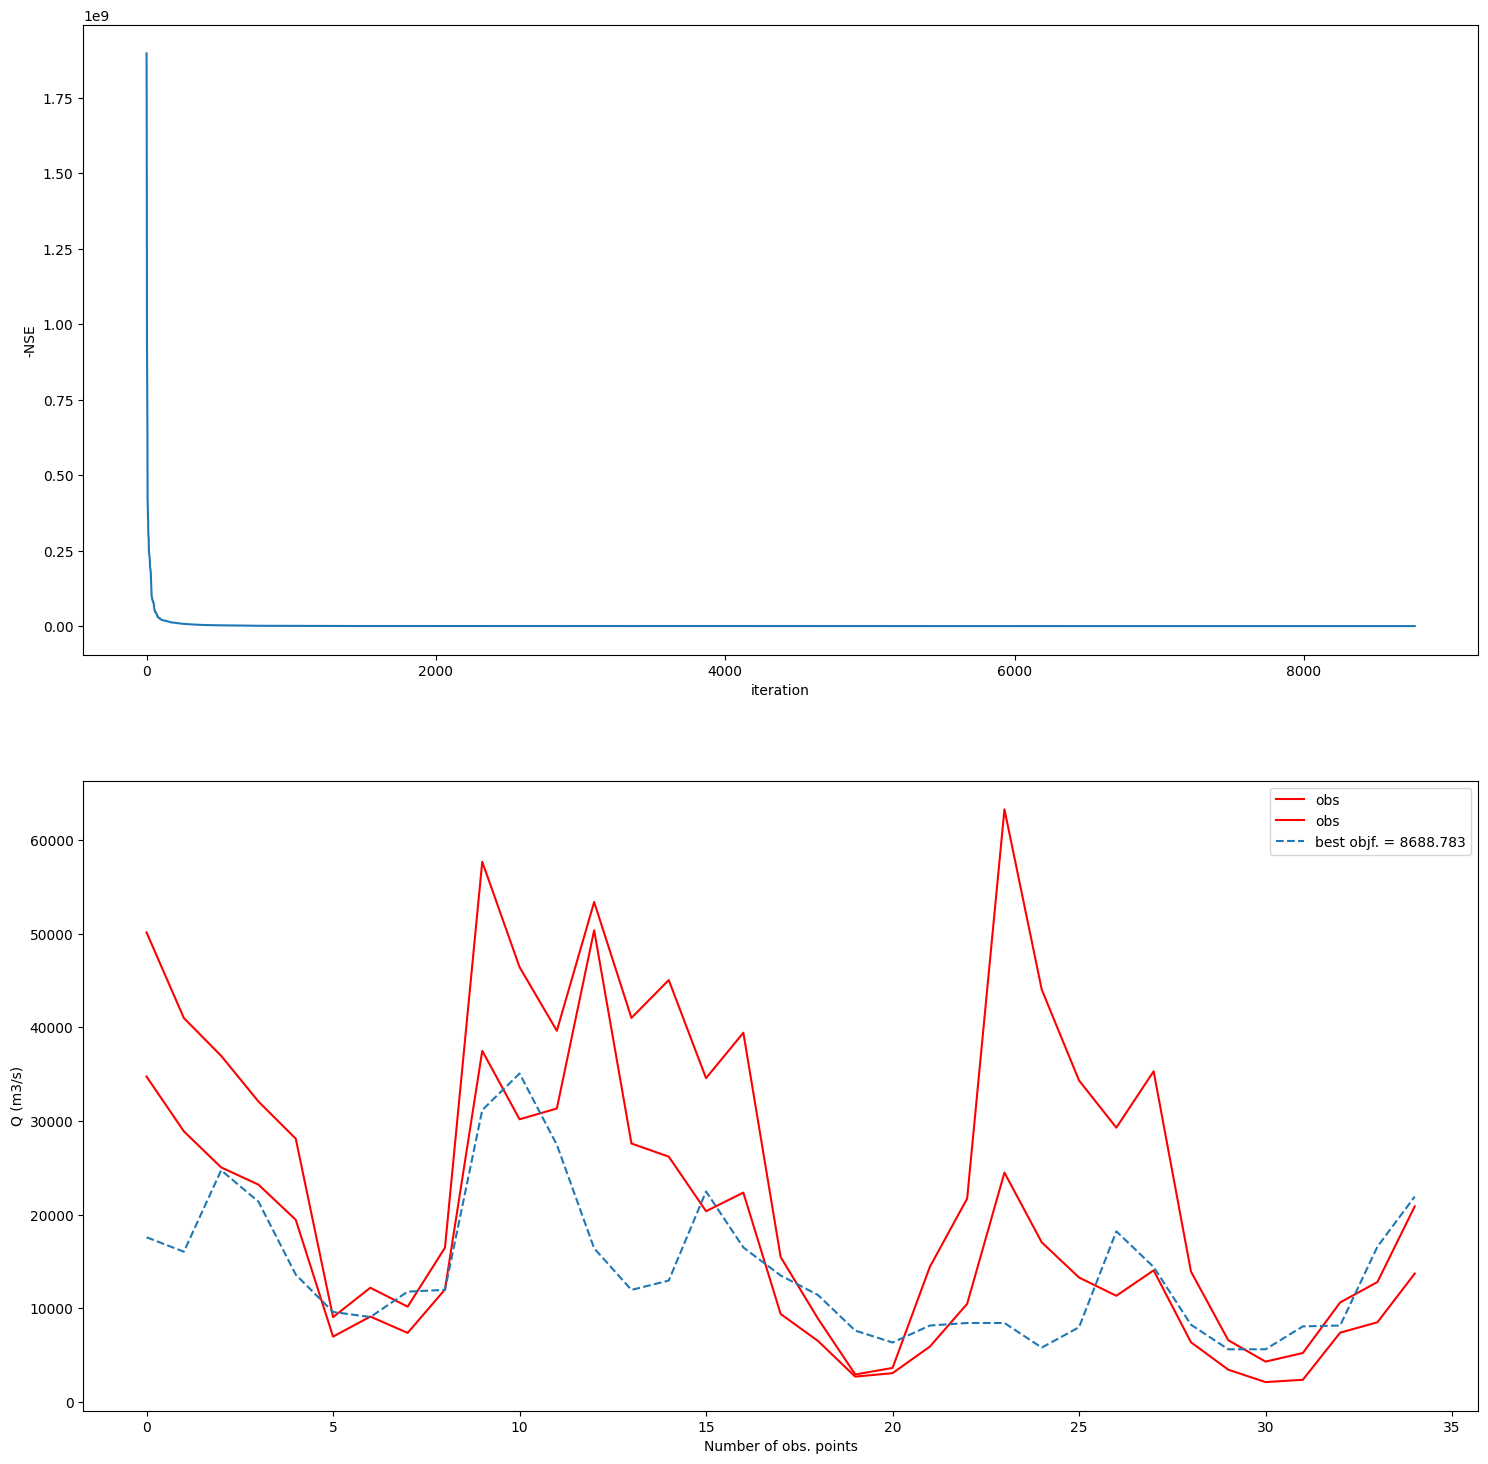

In [7]:
Cal_results = sp.analyser.load_csv_results("Cal_Pre")
bestindex, bestobjf = sp.analyser.get_minlikeindex(Cal_results)

best_model_run = Cal_results[bestindex]
fields = [word for word in best_model_run.dtype.names if word.startswith("sim")]
par_names = [word for word in best_model_run.dtype.names if word.startswith("par")]
best_simulation = np.array(list(best_model_run[fields]))
obs = np.array(spot_setup.evaluation())
best_par = np.array(list(best_model_run[par_names]))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,18))
ax1.plot(Cal_results['like1'])
ax1.set_xlabel("iteration")
ax1.set_ylabel("-NSE")

ax2.plot(obs, "r-", label="obs")
ax2.plot(best_simulation, "--", markersize = 2 ,label="best objf. = " + str(bestobjf))
ax2.set_xlabel("Number of obs. points")
ax2.set_ylabel("Q (m3/s)")
ax2.legend()

# Bayseian

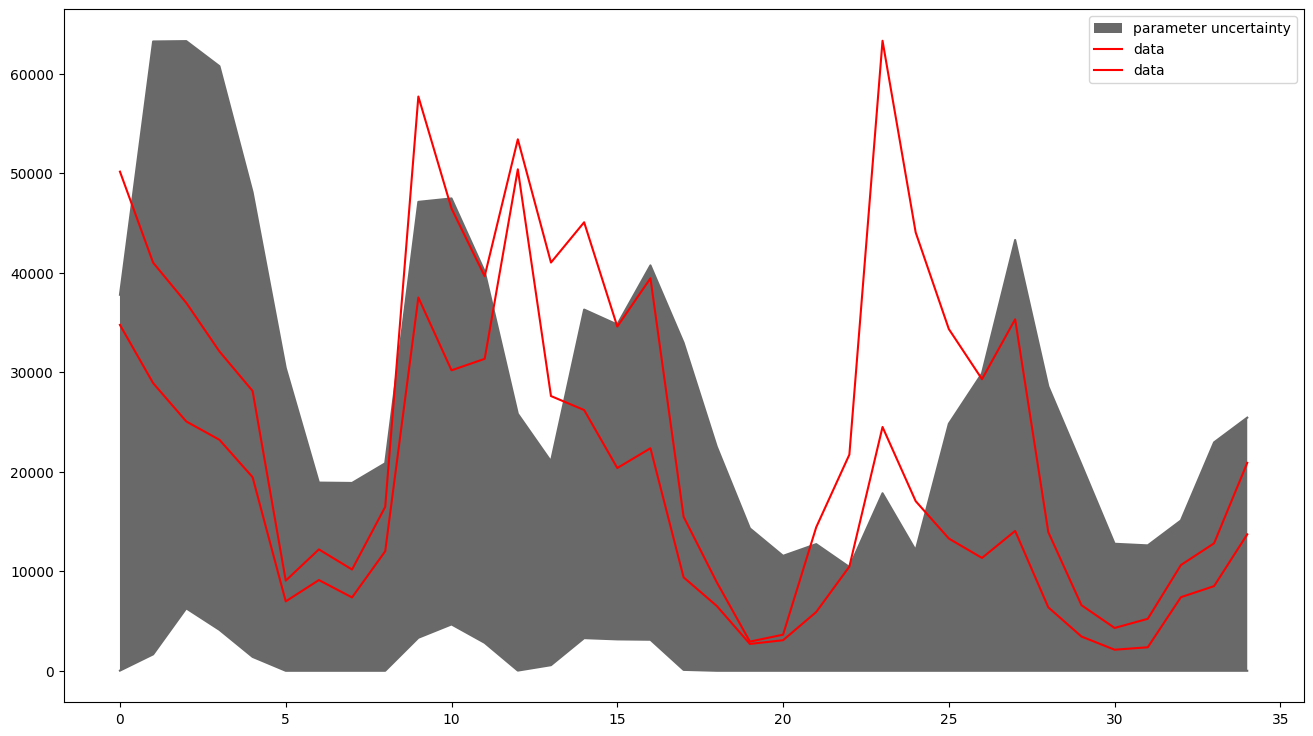

In [12]:
fields=[word for word in Cal_results.dtype.names if word.startswith('sim')]
fig1= plt.figure(figsize=(16,9))
ax = plt.subplot(1,1,1)
q5,q25,q75,q95=[],[],[],[]
for field in fields:
    q5.append(np.percentile(Cal_results[field][-50:-1],2.5))
    q95.append(np.percentile(Cal_results[field][-50:-1],97.5))
ax.plot(q5,color='dimgrey',linestyle='solid')
ax.plot(q95,color='dimgrey',linestyle='solid')
ax.fill_between(np.arange(0,len(q5),1),list(q5),list(q95),facecolor='dimgrey',zorder=0,
                linewidth=0,label='parameter uncertainty')
ax.plot(obs,'r-',label='data')
ax.legend()


IndexError: index 5 is out of bounds for axis 0 with size 5

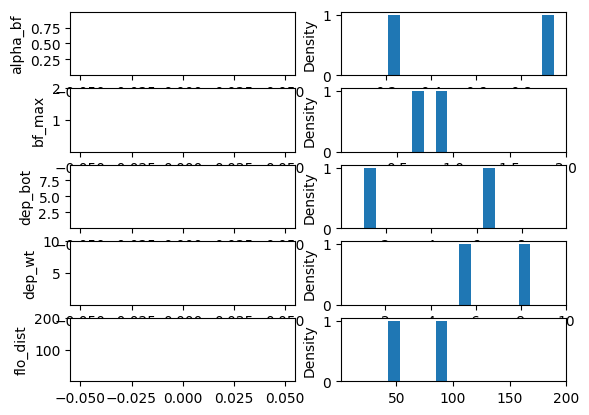

In [126]:
parameters = sp.parameter.get_parameters_array(spot_setup)

fig, ax = plt.subplots(nrows=5, ncols=2)
for par_id in range(len(parameters)):
    sp.analyser.plot_parameter_trace(ax[par_id][0], Cal_results, parameters[par_id])
    sp.analyser.plot_posterior_parameter_histogram(ax[par_id][1], Cal_results, parameters[par_id])

ax[-1][0].set_xlabel('Iterations')
ax[-1][1].set_xlabel('Parameter range')

plt.show()

In [131]:
par = spot_setup.parameters()["random"]
sim = spot_setup.simulation(par)

SWAT+
Revision 60.5.7
Soil & Water Assessment Tool
PC Version
Program reading . . . executing
Date of Sim   2/21/2024 Time  15:12:45
reading from precipitation file         Time  15:12:45
reading from temperature file           Time  15:12:45
reading from solar radiation file       Time  15:12:45
reading from relative humidity file     Time  15:12:45
reading from wind file                  Time  15:12:45
reading from wgn file                   Time  15:12:45
reading from wx station file            Time  15:12:45
Original Simulation        1   1  2017 Yr    1 of    4 Time  15:12:45
Original Simulation        1   2  2017 Yr    1 of    4 Time  15:12:45
Original Simulation        1   3  2017 Yr    1 of    4 Time  15:12:46
Original Simulation        1   4  2017 Yr    1 of    4 Time  15:12:46
Original Simulation        1   5  2017 Yr    1 of    4 Time  15:12:46
Original Simulation        1   6  2017 Yr    1 of    4 Time  15:12:46
Original Simulation        1   7  2017 Yr    1 of    4 Time  1

In [16]:
f = open("par_names.txt", "w")
f.writelines(str(i)+"\n" for i in par_names)
f.close()
np.savetxt("best_par.csv", best_par)